### Twitter sentiment analysis of the three best known players during the Qatar World Cup of 2022    
 - [Michael Yousuf](https://github.com/Michael-yousuf123)

> This project aims to determine how Messi, Ronaldo, and Mbappe, the three most well-known players, were seen by 2022 World Cup spectators in Qatar. This project made use of a number of Python packages and the Natural Language Processing (NLP) technique to gauge the emotions of viewers. Twitter data was scraped using snscrape, NLTK as the natural language toolkit, TextBlob (for Sentiment Classification), MatPlotlib, and WordCloud (for Data Exploration).

#### Import Necessary Libraries
---

In [1]:
import warnings
import string
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter
import seaborn as sns
sns.set_style('darkgrid')
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from nltk import pos_tag # For Parts of Speech tagging

import textblob
from textblob import TextBlob# for sentiment analysis

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer() 

from wordcloud import ImageColorGenerator # for wordcloud generation
from PIL import Image

%matplotlib inline

#### Scrape Data from Twitter
---

In [2]:
# query = '(Mbappe OR Ronaldo OR Messi OR #Mbappe OR #CristianoRonaldo OR #LionelMessi)lang:en since:2022-11-20 until:2022-12-05'
# #lang:en since:2022-11-20 until:2022-12-05
# tweets = []

# for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
#     if i > 50000:
#         break
#     else:
#         tweets.append([tweet.date, tweet.id, tweet.url, tweet.user.username, tweet.user.location,
#                        tweet.content, tweet.likeCount, tweet.retweetCount, tweet.sourceLabel])
# df = pd.DataFrame(tweets, columns= ['Date', 'ID', 'url', 'user_name', 'location', 'content', 'likes', 'retweet', 'source'])
# df.to_csv('twitter.csv', mode='a')  

#### Import Dataframe
---

In [3]:
df1 = pd.read_csv('..raw/twitter.csv', encoding='unicode_escape', engine='python')
df1.head()

,Unnamed: 0,Date,ID,url,user_name,location,content,likes,retweet,source
0,0,2022-12-04 23:59:55+00:00,1.599554e+18,https://twitter.com/GouldHoward/status/1599554...,GouldHoward,"East, East, East London",@Pandamonium1881 Makes a nice change from the ...,1.0,0.0,Twitter for Android
1,1,2022-12-04 23:59:54+00:00,1.599554e+18,https://twitter.com/theongarboy/status/1599554...,theongarboy,"Stock, Essex",@piersmorgan Stick to your Ronaldo âlove inâ...,1.0,0.0,Twitter for iPhone
2,2,2022-12-04 23:59:53+00:00,1.599554e+18,https://twitter.com/TimeToPartey1/status/15995...,TimeToPartey1,NaN,pickford\nkounde stones upa hernandez \nbellin...,0.0,0.0,Twitter for iPhone
3,3,2022-12-04 23:59:52+00:00,1.599554e+18,https://twitter.com/lennoxc/status/15995541070...,lennoxc,NaN,@Sportsnet Mbappe and France. Stronger and fa...,0.0,0.0,Twitter Web App
4,4,2022-12-04 23:59:48+00:00,1.599554e+18,https://twitter.com/mabenavent/status/15995540...,mabenavent,Citizen of the world,How Argentina Came to Love Lionel Messi at the...,1.0,0.0,Twitter Web App


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50004 entries, 0 to 50003
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50004 non-null  object 
 1   Date        50002 non-null  object 
 2   ID          50002 non-null  float64
 3   url         50002 non-null  object 
 4   user_name   50002 non-null  object 
 5   location    29222 non-null  object 
 6   content     50000 non-null  object 
 7   likes       50000 non-null  float64
 8   retweet     50000 non-null  float64
 9   source      50000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.8+ MB


In [5]:
pd.DataFrame({'Missing Values %': df1.isnull().sum()/len(df1.index)*100})

,Missing Values %
Unnamed: 0,0.000000
Date,0.004000
ID,0.004000
url,0.004000
user_name,0.004000
location,41.560675
content,0.007999
likes,0.007999
retweet,0.007999
source,0.007999


### Data Pre-Processing
---

In [6]:
df1['location'] = df1['location'].fillna('unknown')

In [7]:
df1.dropna(inplace=True)

In [8]:
df1 = df1.drop(['Unnamed: 0'], axis=1)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50003
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       50000 non-null  object 
 1   ID         50000 non-null  float64
 2   url        50000 non-null  object 
 3   user_name  50000 non-null  object 
 4   location   50000 non-null  object 
 5   content    50000 non-null  object 
 6   likes      50000 non-null  float64
 7   retweet    50000 non-null  float64
 8   source     50000 non-null  object 
dtypes: float64(3), object(6)
memory usage: 3.8+ MB


In [10]:
stop_words = list(stopwords.words('english'))
emoji = list(UNICODE_EMOJI.keys())

In [11]:
# function for preprocessing tweet in preparation for sentiment analysis
def processed_tweets(text):
    text = text.lower() 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split())
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text)
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)
    # tokenizing words and removing stop words from the tweet text
    tokens = word_tokenize(text)  
    filtered_words = [w for w in tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text

In [12]:
df1['Tweets'] = df1['content'].apply(processed_tweets)

In [13]:
df1.head()

,Date,ID,url,user_name,location,content,likes,retweet,source,Tweets
0,2022-12-04 23:59:55+00:00,1.599554e+18,https://twitter.com/GouldHoward/status/1599554...,GouldHoward,"East, East, East London",@Pandamonium1881 Makes a nice change from the ...,1.0,0.0,Twitter for Android,make nice change messi slobbering lovein ð¤®
1,2022-12-04 23:59:54+00:00,1.599554e+18,https://twitter.com/theongarboy/status/1599554...,theongarboy,"Stock, Essex",@piersmorgan Stick to your Ronaldo âlove inâ...,1.0,0.0,Twitter for iPhone,stick ronaldo âlove inâ pier leave football...
2,2022-12-04 23:59:53+00:00,1.599554e+18,https://twitter.com/TimeToPartey1/status/15995...,TimeToPartey1,unknown,pickford\nkounde stones upa hernandez \nbellin...,0.0,0.0,Twitter for iPhone,pickford kounde stone upa hernandez bellingham...
3,2022-12-04 23:59:52+00:00,1.599554e+18,https://twitter.com/lennoxc/status/15995541070...,lennoxc,unknown,@Sportsnet Mbappe and France. Stronger and fa...,0.0,0.0,Twitter Web App,mbappe france stronger faster team
4,2022-12-04 23:59:48+00:00,1.599554e+18,https://twitter.com/mabenavent/status/15995540...,mabenavent,Citizen of the world,How Argentina Came to Love Lionel Messi at the...,1.0,0.0,Twitter Web App,argentina came love lionel messi world cup via


In [14]:
def messi(n):
  n = str(n)
  resp = n.lower().find("messi")
  if resp != -1:
    return "Messi"
  else:
    return None
def ronaldo(n):
  n = str(n)
  resp = n.lower().find("ronaldo")
  if resp != -1:
    return "Ronaldo"
  else:
    return None
def mbappe(n):
  n = str(n)
  resp = n.lower().find("mbappe")
  if resp != -1:
    return "Mbappe"
  else:
    return None

In [15]:
#applying the function
df1['Messi'] = df1['content'].apply(messi) 
df1['Ronaldo'] = df1['content'].apply(ronaldo) 
df1['Mbappe'] = df1['content'].apply(mbappe)

In [16]:
# replacing empty values with Empty
df1['Messi'] = df1['Messi'].fillna('Empty')
df1['Ronaldo'] = df1['Ronaldo'].fillna('Empty')
df1['Mbappe'] = df1['Mbappe'].fillna('Empty')

In [17]:
# Function for polarity score
def polarity(content):
    return TextBlob(content).sentiment.polarity

# Function to get sentiment type
def sentiment(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive" 

In [18]:
# using the functions to get the polarity and sentiment
df1['Polarity'] = df1['Tweets'].apply(polarity)
df1['Sentiment'] = df1['Polarity'].apply(sentiment)
sent = df1['Sentiment'].value_counts()
sent

Neutral     23701
Positive    19518
Negative     6781
Name: Sentiment, dtype: int64

In [19]:
df2 = df1['Date'].str.split(expand=True)
df2.columns = ['date', 'time']
df1 = df1.join(df2)

#### Exploration
---

In [20]:
bar = sent.rename_axis('Sentiment').to_frame('Total Tweets').reset_index()

In [21]:
bar

,Sentiment,Total Tweets
0,Neutral,23701
1,Positive,19518
2,Negative,6781


<AxesSubplot: xlabel='Sentiment', ylabel='Total Tweets'>

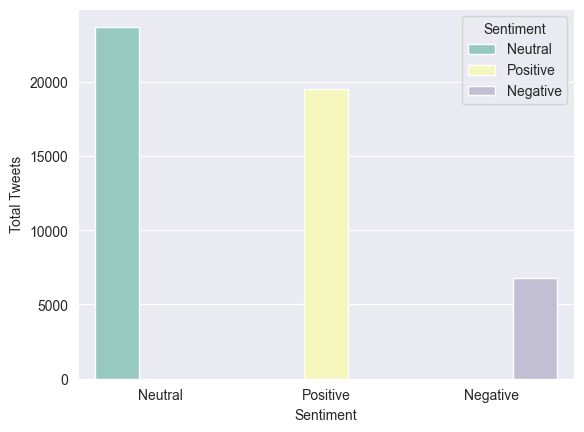

In [22]:
sns.barplot(data=bar, x="Sentiment", y="Total Tweets", hue="Sentiment")

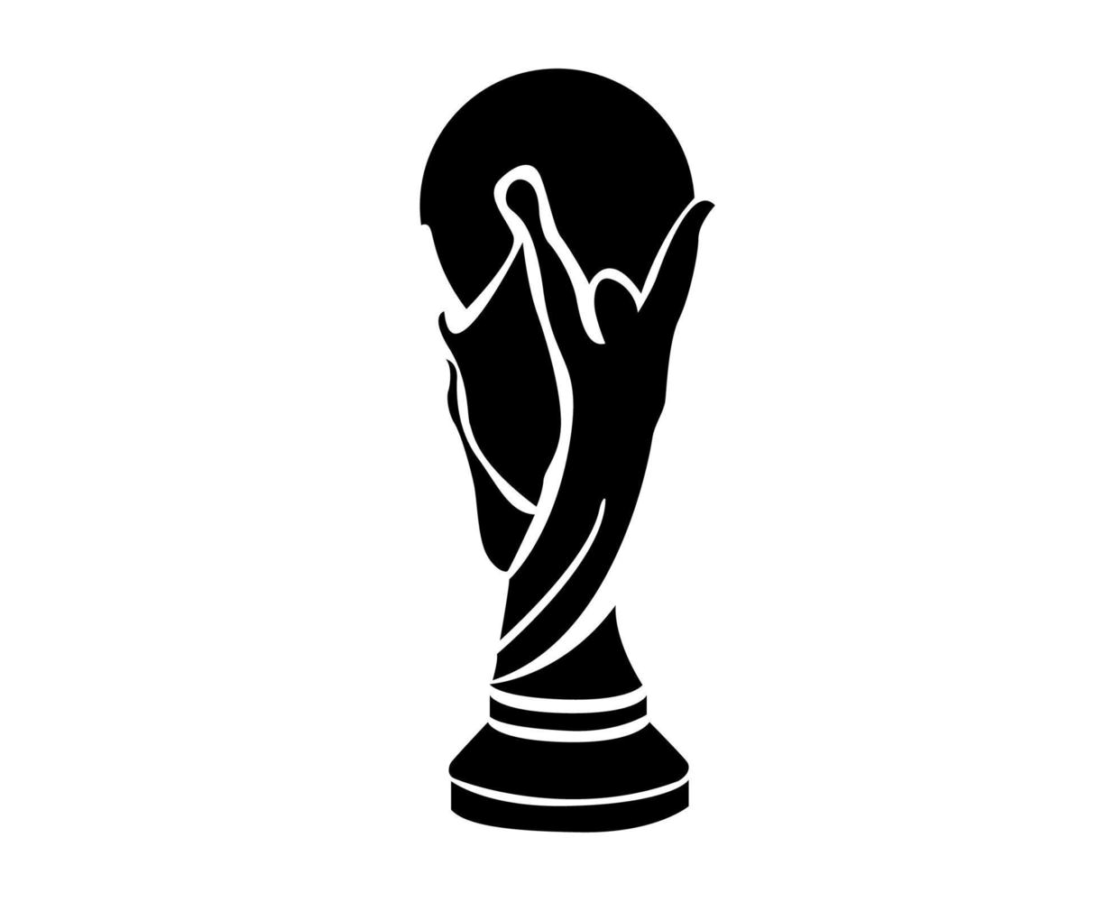

In [23]:
image = np.array(Image.open('/home/miki/Desktop/Projects/Hamoye/twitter-sentiment-analysis/static/cup.png'))
    
fig = plt.figure() # Instantiate the figure object
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(image, cmap=plt.cm.gray, interpolation='bilinear') # Display data as an image
plt.axis('off') # Remove axis
plt.show() # Display image

In [24]:
def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

In [25]:
tweets_string = df1['Tweets'].tolist()
tweets_string = " ".join(tweets_string)

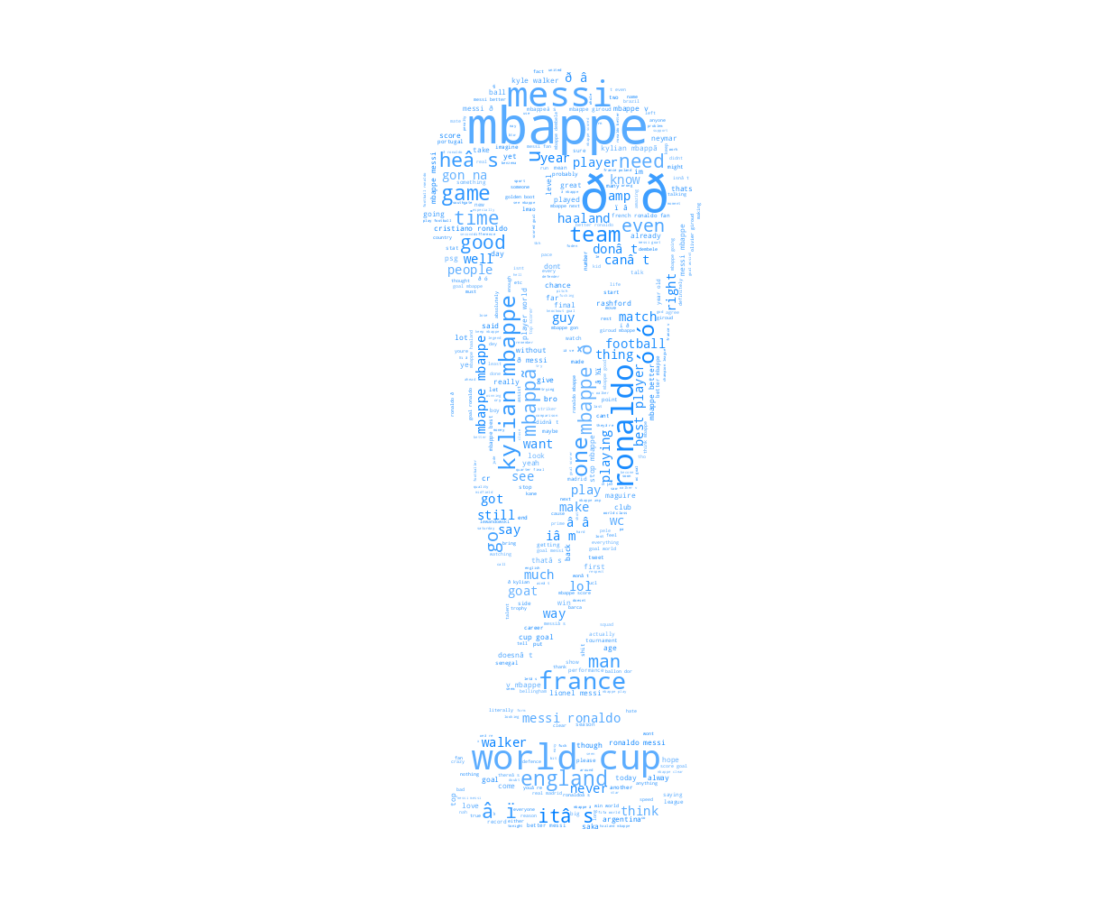

In [26]:
# Instantiate the Twitter word cloud object
wc = WordCloud(background_color='white', max_words=1500, mask=image)

# generate the word cloud
wc.generate(tweets_string)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(wc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()


In [27]:
wc.to_file("../static/wordcloud.png")

#### Export Dataframe
----

In [28]:
df1.to_csv('../data/final/story.csv')

In [29]:
df1.head()

,Date,ID,url,user_name,location,content,likes,retweet,source,Tweets,Messi,Ronaldo,Mbappe,Polarity,Sentiment,date,time
0,2022-12-04 23:59:55+00:00,1.599554e+18,https://twitter.com/GouldHoward/status/1599554...,GouldHoward,"East, East, East London",@Pandamonium1881 Makes a nice change from the ...,1.0,0.0,Twitter for Android,make nice change messi slobbering lovein ð¤®,Messi,Empty,Empty,0.6,Positive,2022-12-04,23:59:55+00:00
1,2022-12-04 23:59:54+00:00,1.599554e+18,https://twitter.com/theongarboy/status/1599554...,theongarboy,"Stock, Essex",@piersmorgan Stick to your Ronaldo âlove inâ...,1.0,0.0,Twitter for iPhone,stick ronaldo âlove inâ pier leave football...,Empty,Ronaldo,Empty,0.1,Positive,2022-12-04,23:59:54+00:00
2,2022-12-04 23:59:53+00:00,1.599554e+18,https://twitter.com/TimeToPartey1/status/15995...,TimeToPartey1,unknown,pickford\nkounde stones upa hernandez \nbellin...,0.0,0.0,Twitter for iPhone,pickford kounde stone upa hernandez bellingham...,Empty,Empty,Mbappe,0.0,Neutral,2022-12-04,23:59:53+00:00
3,2022-12-04 23:59:52+00:00,1.599554e+18,https://twitter.com/lennoxc/status/15995541070...,lennoxc,unknown,@Sportsnet Mbappe and France. Stronger and fa...,0.0,0.0,Twitter Web App,mbappe france stronger faster team,Empty,Empty,Mbappe,0.0,Neutral,2022-12-04,23:59:52+00:00
4,2022-12-04 23:59:48+00:00,1.599554e+18,https://twitter.com/mabenavent/status/15995540...,mabenavent,Citizen of the world,How Argentina Came to Love Lionel Messi at the...,1.0,0.0,Twitter Web App,argentina came love lionel messi world cup via,Messi,Empty,Empty,0.5,Positive,2022-12-04,23:59:48+00:00
